In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from utils.datasets import get_mnist, get_images_for_class, generate_mean_image_for_class, get_random_image
from utils.utils import show_examples, imshow, show_neighbors, show_dataset_examples
from utils.models import AMCNN
from utils.train import train, save, validate, load


In [2]:
model_name = 'model_am.pt'

# I. Preparation
Steps 1-4. allow for the creation and saving of a simple CNN model for digit recognition based on the MNIST dataset. **Skip to step 5 for the loading of a model, if such is available.**

## 1. Load and display the dataset

In [3]:
trainset, trainloader, testset, testloader = get_mnist()

    6     1     7     6


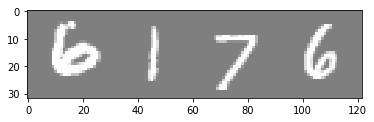

In [4]:
show_dataset_examples(trainloader)

## 2. Create the model

In [9]:
model = AMCNN()
print(model)

AMCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## 3. Train and validate the model

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [11]:
train(model, criterion, optimizer, trainloader, 5)

Epoch: 1	Batch: 300	Loss: 1.285	Accuracy: 0.984
Epoch: 1	Batch: 600	Loss: 0.492	Accuracy: 0.984
Epoch: 1	Batch: 900	Loss: 0.435	Accuracy: 0.984
Epoch: 1	Batch: 938	Loss: 0.071	Accuracy: 0.969
Epoch: 2	Batch: 300	Loss: 0.298	Accuracy: 0.984
Epoch: 2	Batch: 600	Loss: 0.339	Accuracy: 0.922
Epoch: 2	Batch: 900	Loss: 0.393	Accuracy: 0.953
Epoch: 2	Batch: 938	Loss: 0.131	Accuracy: 0.969
Epoch: 3	Batch: 300	Loss: 0.276	Accuracy: 0.938
Epoch: 3	Batch: 600	Loss: 0.303	Accuracy: 0.953
Epoch: 3	Batch: 900	Loss: 0.315	Accuracy: 0.969
Epoch: 3	Batch: 938	Loss: 0.091	Accuracy: 1.000
Epoch: 4	Batch: 300	Loss: 0.244	Accuracy: 0.969
Epoch: 4	Batch: 600	Loss: 0.326	Accuracy: 0.984
Epoch: 4	Batch: 900	Loss: 0.317	Accuracy: 0.984
Epoch: 4	Batch: 938	Loss: 0.068	Accuracy: 1.000
Epoch: 5	Batch: 300	Loss: 0.220	Accuracy: 0.953
Epoch: 5	Batch: 600	Loss: 0.333	Accuracy: 0.984
Epoch: 5	Batch: 900	Loss: 0.313	Accuracy: 0.953
Epoch: 5	Batch: 938	Loss: 0.069	Accuracy: 0.969
Finished Training


In [12]:
validate(model, criterion, testloader)

Test loss: 0.056


## 4. Save the model

In [13]:
save(model, model_name)

## 5. Load the model

In [14]:
model = AMCNN()
model = load(model, model_name)

# II. Activation Maximization

In [15]:
def activation_maximization(input_img, model, class_num, lr, reg_term, epochs):
    input_img.requires_grad = True

    for i in range(epochs):
        input_img.retain_grad()
        
        scores = model(input_img)
        score = scores[0, class_num]
        
        score -= reg_term * input_img.pow(2).sum().sqrt()
        score.backward()

        input_img = input_img + lr * input_img.grad

    return input_img

In [16]:
def activation_maximization_with_post_processing(input_img, model, class_num, lr, reg_term, epochs, normalize=True):
    end_point = activation_maximization(input_img, model, class_num, lr, reg_term, epochs)

    output = model(end_point)
    predicted_class = np.argmax(output.detach().numpy(), 1).item()

    if normalize:
        input_img = (input_img - input_img.max()) / (input_img.max() - input_img.min())
        end_point = (end_point - end_point.max()) / (end_point.max() - end_point.min())
    
    print("Expected class is " + str(class_num))
    print("Recognized class is " + str(predicted_class))
    
    show_neighbors(input_img.detach(), end_point.detach())

## 1. Run Activation Maximization starting from a random image

Expected class is 5
Recognized class is 5


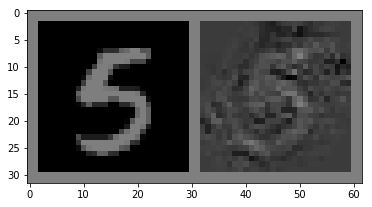

In [20]:
image_random, label_random = get_random_image(trainloader)
label_random = label_random.item()
image_random = image_random.expand(1, 1, 28, 28)

end_point = activation_maximization_with_post_processing(image_random, model, label_random, 0.01, 0.5, 600)

## 2. Run Activation Maximization starting with a random class

Expected class is 6
Recognized class is 6


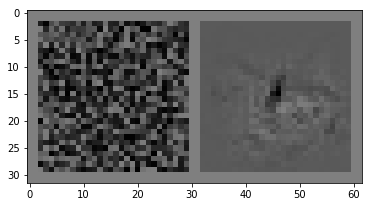

In [23]:
image_noise = torch.rand((1, 1, 28, 28))
label_noise = 6
activation_maximization_with_post_processing(image_noise, model, label_noise, 0.6, 0.5, 600)

## 3. Run Activation Maximization starting from the mean image for a class

Expected class is 9
Recognized class is 9


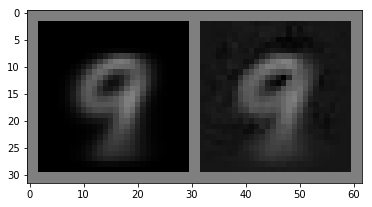

In [24]:
label_mean = 9
image_mean = generate_mean_image_for_class(trainset, label_mean)
image_mean = image_mean.expand(1, 1, 28, 28)

activation_maximization_with_post_processing(image_mean, model, label_mean, 0.05, 0.8, 500)

# III. Saliency Maps

In [25]:
def get_saliency_map(model, input_img):
    input_img.requires_grad = True
    
    input_img.retain_grad()
    scores = model(input_img)
    
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
    score_max.backward()
    
    return torch.max(input_img.grad.data, dim=1)[0]

## 1. Visualize gradient w.r.t. to the image

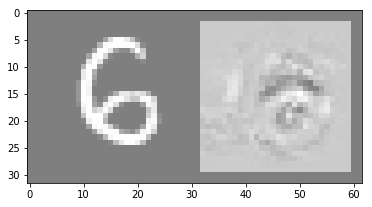

In [27]:
input_img, input_label = get_random_image(trainloader)
saliency_map = get_saliency_map(model, input_img.expand(1, 1, 28, 28))

saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
show = torch.zeros((2, 1, 28, 28))
show[0] = input_img
show[1] = saliency_map

imshow(torchvision.utils.make_grid(show))

## 2. Visualize gradient multiplied by the input image

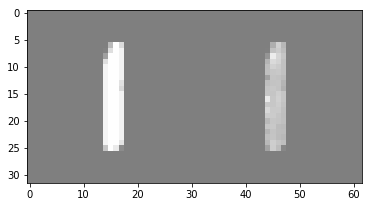

In [28]:
input_img, input_label = get_random_image(trainloader)
saliency_map = get_saliency_map(model, input_img.expand(1, 1, 28, 28))

saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
show = torch.zeros((2, 1, 28, 28))
show[0] = input_img
show[1] = saliency_map * input_img

imshow(torchvision.utils.make_grid(show))